In [19]:
import pandas as pd #modules
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os
import pathlib
from pathlib import Path
from datetime import datetime

In [20]:
import os

def find_reports_in_onedrive():
    """
    Scans the subfolders under the current user's OneDrive folder (including variations like 'OneDrive - Company Name')
    and returns the paths of all folders with the prefix 'reports'.

    Returns:
        list: A list of full paths to folders starting with 'reports', or an empty list if none are found.
    """
    # Get the base path to the user's home directory
    user_home = os.path.expanduser("~")

    # Find the OneDrive folder (handles variations like "OneDrive - Company Name")
    onedrive_folder = None
    for folder in os.listdir(user_home):
        if folder.startswith("OneDrive -"):
            onedrive_folder = os.path.join(user_home, folder)
            break

    if not onedrive_folder:
        raise FileNotFoundError("OneDrive folder not found for the current user.")

    # Search for folders with the prefix 'reports' in the OneDrive directory
    report_folders = []
    for root, dirs, files in os.walk(onedrive_folder):
        for dir_name in dirs:
            if dir_name.lower().startswith("reports"):
                report_folders.append(os.path.join(root, dir_name))

    return report_folders

In [21]:
reports_paths=find_reports_in_onedrive()
reports_paths

['C:\\Users\\jdbustamante\\OneDrive - Duratex SA\\reports_cuchillas',
 'C:\\Users\\jdbustamante\\OneDrive - Duratex SA\\reports_eventos',
 'C:\\Users\\jdbustamante\\OneDrive - Duratex SA\\reports_humidity_measures',
 'C:\\Users\\jdbustamante\\OneDrive - Duratex SA\\reports_ops_pendings',
 'C:\\Users\\jdbustamante\\OneDrive - Duratex SA\\reports_pre-usos_diligenciamiento_no_cumple',
 'C:\\Users\\jdbustamante\\OneDrive - Duratex SA\\reports_quality_deviations',
 'C:\\Users\\jdbustamante\\OneDrive - Duratex SA\\reports_visualizacion_data_produccion',
 'C:\\Users\\jdbustamante\\OneDrive - Duratex SA\\control_room\\reports_causa_rechazos']

In [22]:
str_folder_searcher="reports_visualizacion_data_produccion"
for report_path in reports_paths:
    if str_folder_searcher in report_path:
        path=Path(reports_paths[reports_paths.index(report_path)])
path=Path.joinpath(path,r"source_and_return_data")
path

WindowsPath('C:/Users/jdbustamante/OneDrive - Duratex SA/reports_visualizacion_data_produccion/source_and_return_data')

In [23]:
directory = Path.joinpath(path,"data_plots") #get current work directory
directory.mkdir(exist_ok=True)
matching_files = list(directory.glob("*obj*.xlsx"))  # Busca archivos que contengan 'obj' y tengan extensión .xlsx
print("Archivos encontrados:", matching_files)

Archivos encontrados: [WindowsPath('C:/Users/jdbustamante/OneDrive - Duratex SA/reports_visualizacion_data_produccion/source_and_return_data/data_plots/test_obj_aperturas_nariz.xlsx'), WindowsPath('C:/Users/jdbustamante/OneDrive - Duratex SA/reports_visualizacion_data_produccion/source_and_return_data/data_plots/test_obj_causa_rechazos.xlsx')]


In [24]:
dict_data_pointer={} #dict to store files as dfs
for i in matching_files: # Read the Excel file 
    file_path = str(i)  # Update this with the path
    df = pd.read_excel(file_path)
    print(file_path)
    df_name=file_path.split("obj_")[1].split(".")[0] #split str with "obj_" and the  "." char and take the file name
    date_col="Fecha" #default col name with dates
    if "aperturas" in file_path.lower(): #if excel name file contains "aperturas", change col name with dates
        date_col="Fecha Paro"
    row_numbers_nan = df.index[df[date_col].isna()].tolist() # Get the row numbers where 'Fecha' or 'Fecha Paro' is NaN
    row_numbers = list(set(row_numbers_nan)) # lists of row with nan numbers
    filtered_df = df.drop(index=row_numbers) # Filter the DataFrame to keep only the rows that are not in row_numbers
    dict_data_pointer[f"{df_name}"]=filtered_df #store filtered df in dictionary data pointer
print(list(dict_data_pointer.keys())) #see keys on dictionary to check callability

C:\Users\jdbustamante\OneDrive - Duratex SA\reports_visualizacion_data_produccion\source_and_return_data\data_plots\test_obj_aperturas_nariz.xlsx
C:\Users\jdbustamante\OneDrive - Duratex SA\reports_visualizacion_data_produccion\source_and_return_data\data_plots\test_obj_causa_rechazos.xlsx
['aperturas_nariz', 'causa_rechazos']


In [25]:
data_pointer_ar="aperturas_nariz" #select df of aperturas de nariz
df_ar=dict_data_pointer[data_pointer_ar] #mask df of aperturas de nariz with alias df_ar
dates_col_name_ar="Fecha Paro" #name of col with dates in df
df_ar[dates_col_name_ar] =df_ar.loc[:,dates_col_name_ar].apply(lambda x:x.strftime("%Y-%m-%d")) #convert dates to desired format
df_ar.loc[:,dates_col_name_ar]

0      2025-01-01
1      2025-01-01
2      2025-01-01
3      2025-01-02
4      2025-01-02
          ...    
127    2025-01-14
128    2025-01-14
129    2025-01-14
130    2025-01-14
131    2025-01-14
Name: Fecha Paro, Length: 132, dtype: object

In [26]:
dates_ar=sorted(list(set([ date_str for date_str in df_ar.loc[ :, dates_col_name_ar] ]))) #get dates as str unique of current df
dates_ar

['2025-01-01',
 '2025-01-02',
 '2025-01-03',
 '2025-01-04',
 '2025-01-05',
 '2025-01-06',
 '2025-01-07',
 '2025-01-08',
 '2025-01-09',
 '2025-01-10',
 '2025-01-11',
 '2025-01-12',
 '2025-01-13',
 '2025-01-14']

# Check matches on initial hour & final hour
* remove apertures that are duplicate for changes on dat shift

In [27]:
list_dropped_idx_rows=[]
for date_ar in dates_ar:
    print(date_ar)
    df_seeker=df_ar.loc[df_ar["Fecha Paro"]==date_ar] #filter by date
    rows_df_seeker=df_seeker.index #get idx of df for current date
    last_row=rows_df_seeker[-1] #to avoid out of range
    print(last_row)
    for row in rows_df_seeker:
        print(row)
        if row==last_row:
            continue #jump to next date
        if df_seeker.at[row,"Hora Final"]==df_seeker.at[row+1,"Hora Inicial"]:
            list_dropped_idx_rows.append(row+1) #add idx to be dropped
    print("idxs to drop are {}".format(list_dropped_idx_rows))
df_ar.drop(list_dropped_idx_rows,inplace=True) #drop selected rows for current date
df_ar

2025-01-01
2
0
1
2
idxs to drop are [1, 2]
2025-01-02
6
3
4
5
6
idxs to drop are [1, 2, 5]
2025-01-03
21
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
idxs to drop are [1, 2, 5, 12]
2025-01-04
23
22
23
idxs to drop are [1, 2, 5, 12]
2025-01-05
29
24
25
26
27
28
29
idxs to drop are [1, 2, 5, 12]
2025-01-06
41
30
31
32
33
34
35
36
37
38
39
40
41
idxs to drop are [1, 2, 5, 12, 35, 39, 40]
2025-01-07
57
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
idxs to drop are [1, 2, 5, 12, 35, 39, 40, 44, 48, 50, 51, 56]
2025-01-08
64
58
59
60
61
62
63
64
idxs to drop are [1, 2, 5, 12, 35, 39, 40, 44, 48, 50, 51, 56, 62]
2025-01-09
66
65
66
idxs to drop are [1, 2, 5, 12, 35, 39, 40, 44, 48, 50, 51, 56, 62, 66]
2025-01-10
86
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
idxs to drop are [1, 2, 5, 12, 35, 39, 40, 44, 48, 50, 51, 56, 62, 66, 78]
2025-01-11
100
87
88
89
90
91
92
93
94
95
96
97
98
99
100
idxs to drop are [1, 2, 5, 12, 35, 39, 40, 44, 48, 50, 51, 56, 62, 66, 78, 90, 91, 99]
202

,Linea,Proceso,Tipo Paro,Fecha Paro,Hora Inicial,Hora Final,Descripción Equipo,Modo de Fallo,Obversación,Tiempo Parada,Turno,Calibre,Columna1
0,CRUDO,500 - PRENSA,PARO PROGRAMADO,2025-01-01,21:00:00,05:00:00,ALTO NIVEL DE INVENTARIO - PGR,ALTO NIVEL DE INVENTARIO - PGR,Paro programado de planta,480,3,NaN,NaN
3,CRUDO,500 - PRENSA,PARO PROGRAMADO,2025-01-02,21:00:00,19:46:00,500 PRENSA DIEFFENBACHER,MTTO GENERAL - PGR,Arranque de línea de crudo. Se corrigen condic...,406,3,11 TAPAS,152426
4,CRUDO,"400 - FORMACION, PRE-PRENSADO & CORTE",PRODUCCIÓN,2025-01-02,20:02:00,20:09:00,400 FORMACION Y PREPRENSA,VARIACION HUMEDAD - PRO,Se abrea nariz y se evacúa la fibra,6,3,11 TAPAS,152426
6,CRUDO,"600 - CORTE, ENFRIAMIENTO & APILADO",PRODUCCIÓN,2025-01-02,20:15:00,20:31:00,600.631 SIERRA DIAGONAL,TABLERO EXPLOTADO - PRO,Se pierdesecuencia en la sierra diagonal debid...,16,3,11 TAPAS,152426
7,CRUDO,500 - PRENSA,PRODUCCIÓN,2025-01-03,21:05:00,21:16:00,500 PRENSA DIEFFENBACHER,SENSOR OBSTRUIDO - PRO,Sensor de cadena lado de operación de la cadena,11,1,9,152433
...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,CRUDO,"400 - FORMACION, PRE-PRENSADO & CORTE",MECÁNICO,2025-01-14,11:50:00,12:41:00,400.413.01 SIERRA LATERAL LADO IZQUIERDO,AJUSTE TECNICO - MEC,se revisa sierra lateral izquierda,51,2,11 TAPAS,152822
126,CRUDO,200 - PREPARACION DE FIBRA,MECÁNICO,2025-01-14,12:02:00,12:03:00,200.227 TORNILLO ESTRUJADOR,CHEQUE PEGADO - MEC,Se interviene circuito suministro de agua a te...,1,2,11 TAPAS,152822
129,CRUDO,"400 - FORMACION, PRE-PRENSADO & CORTE",PCP,2025-01-14,14:15:00,15:00:00,400 FORMACION Y PREPRENSA,CAMBIO DE CALIBRE - PCP,Cambio de 25MM a 3MM,45,3,3,NaN
130,CRUDO,"400 - FORMACION, PRE-PRENSADO & CORTE",PCP,2025-01-14,15:38:00,15:58:00,400 FORMACION Y PREPRENSA,CAMBIO DE CALIBRE - PCP,Cambio de calibre 3 mm a 4 mm,20,3,4,152871


In [28]:
amt_apertura_nariz=df_ar.groupby(dates_col_name_ar).count().T.iloc[0] #for each production stop there is an apertura de nariz and take those values
amt_apertura_nariz=np.array(amt_apertura_nariz) #agsin amt of aperturas per day on array of numpy
amt_apertura_nariz

array([ 1,  3, 14,  2,  6,  9, 11,  6,  1, 19, 11,  4, 12, 10])

In [29]:
data_pointer="causa_rechazos" #start with df with rejected panels number per day and cause
df=dict_data_pointer[data_pointer] #mask causa_rechazos with df alias
dates_col_name="Fecha" #date col on causa_rechazos
cause_col_name="Notas movimiento" #rejected causes col name
nan_causes="causa no especifica" #str to replace nans on rejected causes col name
df.loc[:,[cause_col_name]]=df.loc[:,[cause_col_name]].fillna(value=nan_causes) #particular cleasing for causa_rechazos df; fill not specified rejected causes
df.loc[:,[cause_col_name]]

,Notas movimiento
0,causa no especifica
1,ALTO CALIBRE
2,BAJO CALIBRE
3,ALTO CALIBRE
4,ALTO CALIBRE
5,BAJO CALIBRE
6,AMPOLLADAS
7,AMPOLLADAS
8,AMPOLLADAS
9,ALTO CALIBRE


### New approach:
* Drop date col on causa rechazos and replace w/ str date col
* Convert str to datetime to make call correctly

In [30]:
try: #attemp to drop cummulative total row
    df=df.loc[1:,:] #drop first row cause is a total row
except:
    pass
df.reindex(range(len(df)))
df[dates_col_name]=df.loc[:,dates_col_name].apply(lambda x:x.strftime("%Y-%m-%d")) #convert dates to desired format
df.loc[:,dates_col_name]

C:\Users\jdbustamante\AppData\Local\Temp\ipykernel_19272\1804187861.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[dates_col_name]=df.loc[:,dates_col_name].apply(lambda x:x.strftime("%Y-%m-%d")) #convert dates to desired format


1     2025-01-03
2     2025-01-03
3     2025-01-03
4     2025-01-04
5     2025-01-04
6     2025-01-05
7     2025-01-05
8     2025-01-06
9     2025-01-06
10    2025-01-06
11    2025-01-06
12    2025-01-07
13    2025-01-07
14    2025-01-07
15    2025-01-07
16    2025-01-07
17    2025-01-07
18    2025-01-08
19    2025-01-08
20    2025-01-08
21    2025-01-10
22    2025-01-10
23    2025-01-10
Name: Fecha, dtype: object

In [31]:
ignored_articles=["de","s","-"] #+#articles to remove for cause name-->make basic cause labelling

In [32]:
def remove_specific_chars(string=None):
    new_cause_basic_name=string
    nan_causes="causa no especifica" #str to replace nans on rejected causes col name
    ignored_articles=["de","s","-"] #+#articles to remove for cause name-->make basic cause labelling
    ignored_digits=[str(number) for number in range(9+1)] #list to remove numbers from string
    for ignored_article in ignored_articles:
        if string==nan_causes: #do not remove chars on nan_causes
            continue
        new_cause_basic_name=new_cause_basic_name.replace(ignored_article,"") #remove articles from cause name
        new_cause_basic_name=" ".join(new_cause_basic_name.split()) #remove spaces
        new_cause_basic_name="".join([i for i in new_cause_basic_name if not i.isdigit()])
        print(new_cause_basic_name)
    return new_cause_basic_name

In [33]:
causes=[str(i).lower() for i in df[cause_col_name].unique()] #day causes on lower case
for idx_cause,cause in enumerate(causes): #run through causes and idx from 0-len(causes)
    causes[idx_cause]=remove_specific_chars(string=cause) #" ".join(new_cause_basic_name.split()) #clean str for extra spaces
causes=list(set(causes)) #get unique instances of causes (not duplicates on causes), sorted alpha descending
time_stamp_dates=list([ i for i in [ df.loc[ :, dates_col_name].unique() ][::-1] ][0]) #get dates as time_stamps
#dates = [str(j).split(" ")[0] for j in time_stamp_dates]  # dates to convert each time stamp to str and remove hh:mm:ss info
dates=sorted(time_stamp_dates) #sorted dates aperturas ascending
causes=sorted(causes)
dates,causes

alto calibre
alto calibre
alto calibre
bajo calibre
bajo calibre
bajo calibre
ampolladas
ampollada
ampollada
maltrato
maltrato
maltrato


(['2025-01-03',
  '2025-01-04',
  '2025-01-05',
  '2025-01-06',
  '2025-01-07',
  '2025-01-08',
  '2025-01-10'],
 ['alto calibre',
  'ampollada',
  'bajo calibre',
  'causa no especifica',
  'maltrato'])

### Unique ID color for every cause

In [34]:
colors_id_path=Path.joinpath(directory,"valid_causes_rejected_panels.txt")
causes_colors_df = pd.read_csv(colors_id_path, sep=",",index_col=0,header=0,on_bad_lines='skip')
causes_colors_df["variations"]=causes_colors_df["variations"].apply(lambda x:x.replace(";",","))
causes_colors_df

,variations,acronyms,color
idx,,,
0,"[""explotado"",""explotada""]",[],'1'
1,"[""alto calibre""]","[""a.c""]",'2'
2,"[""bajo calibre""]","[""b.c""]",'3'
3,"[""retencion""]",[],'4'
4,"[""maltratado"",""maltratada"",""maltrato""]",[],'4'
5,"[""mancha"",""manchada"",""manchado""]",[],'5'
6,"[""falta de curado""]","[""f.c"";""f.curado""]",'6'
7,"[""ampollado"",""ampollada""]",[],'7'
8,"[""master panel corto""]","[""m.p corto"";""m.p.c""]",'8'


# In case rejected causes is empty:
* generate dummy causes, all current valid causes from df of valid causes

In [35]:
if len(causes)<1: #causes list is empty
    causes=[eval(element)[0] for element in list(causes_colors_df.loc[:,list(causes_colors_df.columns)[0]].values)]
causes

['alto calibre',
 'ampollada',
 'bajo calibre',
 'causa no especifica',
 'maltrato']

## Dates check
* for now, aperturas de nariz file contains dates that are missing on causa rechazos file

In [36]:
while dates_ar!=dates and eval(input()): # [:len(dates)]
    for date_ar_idx,date_ar in enumerate( dates_ar ): #run through dates of aperturas
        print(date_ar_idx)
        print("current date of apertures ",date_ar)
        print("current dates of causas rechazos ",dates)
        if date_ar not in dates: #replace current dates with dates of aperturas de nariz: non missing dates current file
            print("{} of apertures not in {}".format(date_ar,dates))
            dates.insert(date_ar_idx,date_ar)
            print("nueva lista de fechas para causa rechazos ",dates)
dates==dates_ar

 True


0
current date of apertures  2025-01-01
current dates of causas rechazos  ['2025-01-03', '2025-01-04', '2025-01-05', '2025-01-06', '2025-01-07', '2025-01-08', '2025-01-10']
2025-01-01 of apertures not in ['2025-01-03', '2025-01-04', '2025-01-05', '2025-01-06', '2025-01-07', '2025-01-08', '2025-01-10']
nueva lista de fechas para causa rechazos  ['2025-01-01', '2025-01-03', '2025-01-04', '2025-01-05', '2025-01-06', '2025-01-07', '2025-01-08', '2025-01-10']
1
current date of apertures  2025-01-02
current dates of causas rechazos  ['2025-01-01', '2025-01-03', '2025-01-04', '2025-01-05', '2025-01-06', '2025-01-07', '2025-01-08', '2025-01-10']
2025-01-02 of apertures not in ['2025-01-01', '2025-01-03', '2025-01-04', '2025-01-05', '2025-01-06', '2025-01-07', '2025-01-08', '2025-01-10']
nueva lista de fechas para causa rechazos  ['2025-01-01', '2025-01-02', '2025-01-03', '2025-01-04', '2025-01-05', '2025-01-06', '2025-01-07', '2025-01-08', '2025-01-10']
2
current date of apertures  2025-01-03


True

# Generate data to plotting

In [37]:
weight_counts={i:[0]*len(causes) for i in dates} #make dict to store panel per cause per day
weight_counts

{'2025-01-01': [0, 0, 0, 0, 0],
 '2025-01-02': [0, 0, 0, 0, 0],
 '2025-01-03': [0, 0, 0, 0, 0],
 '2025-01-04': [0, 0, 0, 0, 0],
 '2025-01-05': [0, 0, 0, 0, 0],
 '2025-01-06': [0, 0, 0, 0, 0],
 '2025-01-07': [0, 0, 0, 0, 0],
 '2025-01-08': [0, 0, 0, 0, 0],
 '2025-01-09': [0, 0, 0, 0, 0],
 '2025-01-10': [0, 0, 0, 0, 0],
 '2025-01-11': [0, 0, 0, 0, 0],
 '2025-01-12': [0, 0, 0, 0, 0],
 '2025-01-13': [0, 0, 0, 0, 0],
 '2025-01-14': [0, 0, 0, 0, 0]}

# TODO
* apply directive to clean classifications and search correctly on causa rechazos

In [38]:
name_of_rejected_panels_col="Salidas (inv.)" #actual name of rejected panels col-->start completion of panel per cause per day
for date in dates: #run through dates
    try: #------->try to search by respective date. except: date not in cause rechazos, generate a date entry on weight counts with all causes on 0<-----------
        print(date, type(date))
        print(date_col,cause_col_name)
        df_cols_date_search=df.loc[:,:"Notas movimiento"].groupby([date_col,cause_col_name]).sum().T.loc[:,date] #total amt of panels per cause, per date
    except: #ValueError:
        #print(ValueError)
        continue #next iteration, current date with all 0s on causes
    cols_date_search_causes=df_cols_date_search.columns #causes col names for current date filter
    for cause,z in zip(causes,range(len(causes))): # run through causes and idx from 0-len(causes)
        for current_date_cause in cols_date_search_causes: # # run through causes per day
            current_cause=current_date_cause.lower() #apply lower case convertion
            current_cause=remove_specific_chars(string=current_cause) #cause on current df, remove articles to basic cause name
            if cause in current_cause: #cause match case: if cause in current cause per day, 
                panels_per_cause=df_cols_date_search[current_date_cause].T[name_of_rejected_panels_col] #get panels rejected by current cause
                print(f"{cause}:"+str(panels_per_cause)) #print cause and panels
                weight_counts[date][z]=panels_per_cause #store on dict date:
    #print(date)
weight_counts

2025-01-01 <class 'str'>
Fecha Notas movimiento
2025-01-02 <class 'str'>
Fecha Notas movimiento
2025-01-03 <class 'str'>
Fecha Notas movimiento
alto calibre
alto calibre
alto calibre
alto calibre:4
bajo calibre
bajo calibre
bajo calibre
alto calibre
alto calibre
alto calibre
bajo calibre
bajo calibre
bajo calibre
alto calibre
alto calibre
alto calibre
bajo calibre
bajo calibre
bajo calibre
bajo calibre:4
alto calibre
alto calibre
alto calibre
bajo calibre
bajo calibre
bajo calibre
alto calibre
alto calibre
alto calibre
bajo calibre
bajo calibre
bajo calibre
2025-01-04 <class 'str'>
Fecha Notas movimiento
alto calibre
alto calibre
alto calibre
alto calibre:3
bajo calibre
bajo calibre
bajo calibre
alto calibre
alto calibre
alto calibre
bajo calibre
bajo calibre
bajo calibre
alto calibre
alto calibre
alto calibre
bajo calibre
bajo calibre
bajo calibre
bajo calibre:6
alto calibre
alto calibre
alto calibre
bajo calibre
bajo calibre
bajo calibre
alto calibre
alto calibre
alto calibre
bajo ca

{'2025-01-01': [0, 0, 0, 0, 0],
 '2025-01-02': [0, 0, 0, 0, 0],
 '2025-01-03': [4, 0, 4, 0, 0],
 '2025-01-04': [3, 0, 6, 0, 0],
 '2025-01-05': [0, 50, 0, 0, 0],
 '2025-01-06': [12, 13, 0, 0, 0],
 '2025-01-07': [10, 12, 14, 0, 0],
 '2025-01-08': [16, 0, 3, 2, 0],
 '2025-01-09': [0, 0, 0, 0, 0],
 '2025-01-10': [11, 0, 11, 0, 3],
 '2025-01-11': [0, 0, 0, 0, 0],
 '2025-01-12': [0, 0, 0, 0, 0],
 '2025-01-13': [0, 0, 0, 0, 0],
 '2025-01-14': [0, 0, 0, 0, 0]}

In [39]:
construc_data_to_stacked=list(weight_counts.items()) #get keys and values of weight_counts
array_rejected_panels_per_cause_per_day=np.zeros((len(causes),len(dates))) #make array of zeros to replace data from rows as cols
for i in range(len(construc_data_to_stacked)): # run through idx from 0-len(amt of dates)
    array_rejected_panels_per_cause_per_day[:,i]=np.array(construc_data_to_stacked[i][-1]).T #take panels values, transpose and store on array of rejected panels
weight_count_causes={i:array_rejected_panels_per_cause_per_day[j,:] for i,j in zip(causes, range(len(causes)))} #reconstruct weight counts: keys as causes, rows rejected panels per specific cause per day
weight_count_causes

{'alto calibre': array([ 0.,  0.,  4.,  3.,  0., 12., 10., 16.,  0., 11.,  0.,  0.,  0.,
         0.]),
 'ampollada': array([ 0.,  0.,  0.,  0., 50., 13., 12.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.]),
 'bajo calibre': array([ 0.,  0.,  4.,  6.,  0.,  0., 14.,  3.,  0., 11.,  0.,  0.,  0.,
         0.]),
 'causa no especifica': array([0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.]),
 'maltrato': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0.])}

In [40]:
bar_cause_labels=[[]]*len(causes) #make labels to display on rectangle bar data: inside rectangle to do not display 0 values
for bar_values,bar_idx,cause in zip(bar_cause_labels,range(len(causes)),causes): #run through bbar_cause_labels and idx from 0-len(causes) and causes
    bar_values=[str(int(weight_count_causes[cause][i])).replace("0"," ") if len( str(int(weight_count_causes[cause][i])) )<2 else str(int(weight_count_causes[cause][i])) for i in range(len(dates)) ] #replace 0 only values with " " #
    bar_cause_labels[bar_idx]=bar_values #agsin rectangle value
bar_cause_labels

[[' ', ' ', '4', '3', ' ', '12', '10', '16', ' ', '11', ' ', ' ', ' ', ' '],
 [' ', ' ', ' ', ' ', '50', '13', '12', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
 [' ', ' ', '4', '6', ' ', ' ', '14', '3', ' ', '11', ' ', ' ', ' ', ' '],
 [' ', ' ', ' ', ' ', ' ', ' ', ' ', '2', ' ', ' ', ' ', ' ', ' ', ' '],
 [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '3', ' ', ' ', ' ', ' ']]

# TODO
* organizar orden de stacked bar para mostrar primero las causas con más paneles rechazados

In [41]:
colors_available=mcolors.TABLEAU_COLORS
colors_available

{'tab:blue': '#1f77b4',
 'tab:orange': '#ff7f0e',
 'tab:green': '#2ca02c',
 'tab:red': '#d62728',
 'tab:purple': '#9467bd',
 'tab:brown': '#8c564b',
 'tab:pink': '#e377c2',
 'tab:gray': '#7f7f7f',
 'tab:olive': '#bcbd22',
 'tab:cyan': '#17becf'}

In [42]:
colors_available_keys=list(colors_available)
#colors_available_keys.remove('tab:olive')
colors_available_keys

['tab:blue',
 'tab:orange',
 'tab:green',
 'tab:red',
 'tab:purple',
 'tab:brown',
 'tab:pink',
 'tab:gray',
 'tab:olive',
 'tab:cyan']

In [43]:
causes_color_idxs=[]
for j in range(len(causes)):
    for i in range(len(causes_colors_df)):
        if causes[j] in causes_colors_df["variations"][i]:
            causes_color_idxs.append(int(eval(causes_colors_df.at[i,"color"])))
causes_color_idxs

[2, 7, 3, 9, 4]

In [44]:
colors_choosen={cause:colors_available_keys[idx_color] for cause,idx_color in zip(causes,causes_color_idxs)}
colors_choosen

{'alto calibre': 'tab:green',
 'ampollada': 'tab:gray',
 'bajo calibre': 'tab:red',
 'causa no especifica': 'tab:cyan',
 'maltrato': 'tab:purple'}

In [45]:
fontsz=12 #define font size of plot components
matplotlib.rcParams.update({'font.size': fontsz}) #update font size for plot components of matplotlib

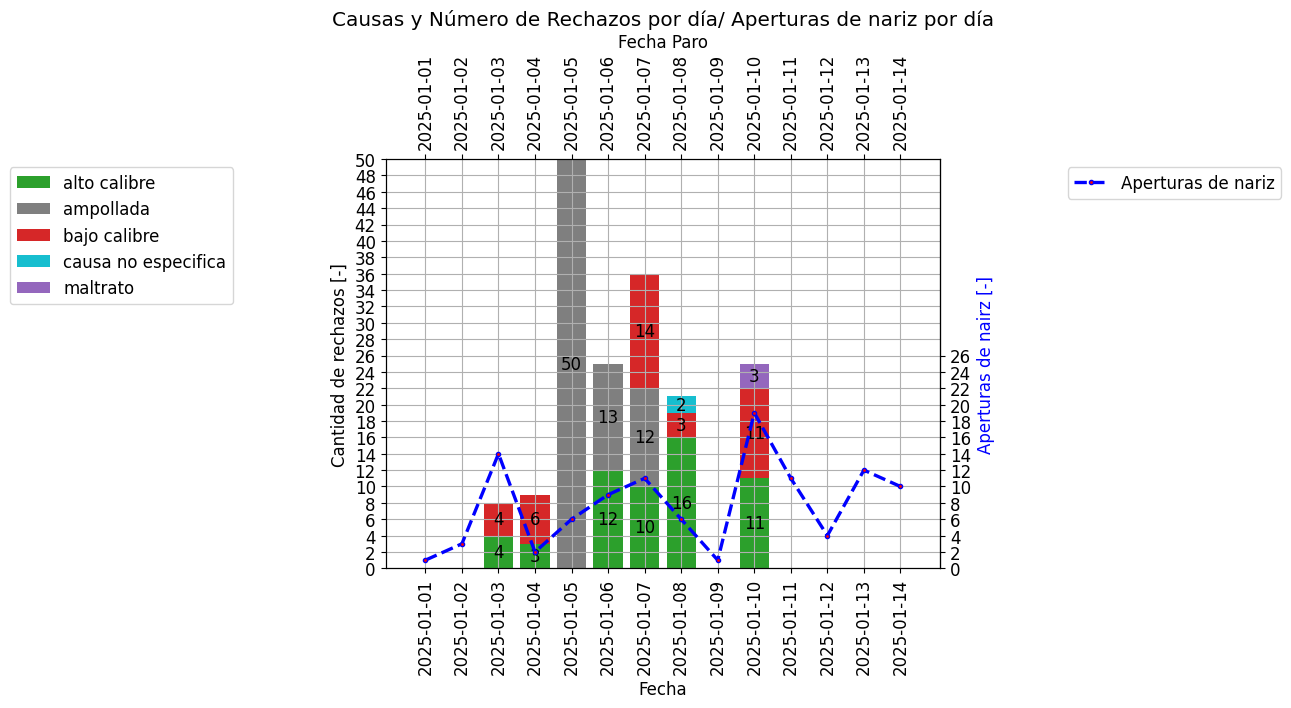

In [46]:
fig, ax = plt.subplots()
fig.tight_layout()  # Adjust layout to prevent clipping of labels
#fig.set_figheight(8)
#fig.set_size_inches(50, 40) #set plot size
#plot aperturas
amt_dates=len(dates)
bottom = np.zeros(amt_dates) #initial axis for stacked bars plotting
plt.grid() #make grid mesh
max_bottom=0 #to store max of bottoms in construction of bar
for (data_label,weight_count),bar_value_stick,color_cause in zip(weight_count_causes.items(),bar_cause_labels,colors_choosen.values()): #run through dates, rejected per cause per dates, labels of values of rejected per cause per day 
    p = ax.bar(dates, weight_count, label=data_label, bottom=bottom,color=color_cause) #take bar plot elements: rectangle(attribute 1, attribute 2, ...)
    bottom += weight_count #make new start to plot next top rectangle
    check_bottom=np.max(bottom)
    if check_bottom>max_bottom:
        max_bottom=check_bottom #to generate ylim of causas rechazos
    ax.bar_label(p, labels=bar_value_stick, label_type='center',color="black",padding=0) #add bar height str value on bar center
leq=ax.legend(loc="best") #generate legend box for bar plot
# Get the bounding box of the original legend
bb = leq.get_bbox_to_anchor().transformed(ax.transAxes.inverted()) 
# Change to location of the legend. 
xOffset = -1.2
bb.x0 += xOffset
bb.x1 += xOffset*(1.05)
leq.set_bbox_to_anchor(bb, transform = ax.transAxes)
amt_xticks=range(len(dates))
ax.set_xticks(amt_xticks)
ax.set_xticklabels(dates,rotation=90) #rotate x axis labels 90º to be displayed vertically
ax.set_xlabel(dates_col_name) #name of bar plot x axis
rejected_panels_values=np.array(list(weight_counts.values()))
max_y_axis=np.max(rejected_panels_values) #get max of all data
ax.set_yticks(np.arange(0, max_y_axis+max_bottom, 2)) #set y axis label values: axis pitch=10 unds
ax.set_ylabel("Cantidad de rechazos [-]") #y axis name for bar plot
ax.set_aspect('auto')
#plot aperturas
ax_ar = ax.twiny() #copy bar plot element to plot easily amt of aperturas de nariz
ax_ar.sharex(ax)
amt_xticks_ar=range(len(dates))
ax_ar.set_xticks(amt_xticks_ar)
ax_ar.set_xticklabels(dates_ar,rotation=90) #rotate x axis labels 90º to be displayed vertically
ax_ar.set_xlabel(dates_col_name_ar) #name of bar plot x axis
ax_ar.plot(amt_apertura_nariz,label="Aperturas de nariz",linewidth=fontsz/5,linestyle='dashed',color="b",marker=".",
        markersize=fontsz/2,markerfacecolor='red') #plot aperturas de nariz by day
ax_ar.set_xticklabels(dates_ar,rotation=90)
leq_ar=ax_ar.legend(loc="upper right") #move legend box of aperturas to left to not cover bar plot legend box #bbox_to_anchor=(0.7, 1),
# Get the bounding box of the original legend
bb_ar = leq_ar.get_bbox_to_anchor().transformed(ax.transAxes.inverted()) 
# Change to location of the legend. 
xOffset = 0.6
bb_ar.x0 += xOffset
bb_ar.x1 += xOffset*(1.05)
leq_ar.set_bbox_to_anchor(bb_ar, transform = ax.transAxes)
secax_y2 = ax_ar.secondary_yaxis("right", functions=(lambda x: x, lambda x: x)) #make new y axis for aperturas
secax_y2.set_ylabel("Aperturas de nairz [-]",color='b') #change color of y axis to blue
max_aperturas=np.max(amt_apertura_nariz) #to set max lim of aperturas y axis
secax_y2.set_yticks(np.arange(0, max_aperturas*(1.4), 2)) #change y axis limits and pitch to 5
ax_ar.set_aspect('auto')
imgs_folder="/imgs_reports_daily" #str with name to save plots
imgs_type_folder="/qty_rejecteds_apertures"
imgs_year_folder=f"/year_{dates[0].split("-")[0]}"
imgs_month_folder=f"/month_{dates[0].split("-")[1]}"
img_name="/fail_modes_Qty_rechazos" #name of img file
str_today=datetime.today().strftime('%Y-%m-%d') #asign date of generation
plt.title("Causas y Número de Rechazos por día/ Aperturas de nariz por día") #make title
directory_to_save = Path(str(directory)+imgs_folder+imgs_type_folder+imgs_year_folder+imgs_month_folder) # get directory to save plot
directory_to_save.mkdir(exist_ok=True)
plt.savefig(str(directory_to_save)+img_name+dates[0]+"_"+dates_ar[-1]+"_"+str_today+".png", bbox_inches='tight') #store img plot
plt.show()

In [47]:
df_to_export=pd.concat([df, df_ar], axis=1) #merge dfs to store data as old queries

In [48]:
df_to_export.to_excel(str(directory)+f"/old_queries/{data_pointer}_{data_pointer_ar}_"+dates[0]+"_"+dates_ar[-1]+".xlsx") #save current query to old_queries

# Plot with sorted stacked bars
* make innner outter index data frame, sort by inner index (causes)

In [49]:
"""times=[]
for i in dates:
    for j in range(len(causes)):
        times.append(i)
times_causes_array=[times,causes*len(dates)]
times_causes_array"""

'times=[]\nfor i in dates:\n    for j in range(len(causes)):\n        times.append(i)\ntimes_causes_array=[times,causes*len(dates)]\ntimes_causes_array'

In [50]:
"""data=np.array(list(weight_count_causes.values())).T.flatten()
data.shape"""

'data=np.array(list(weight_count_causes.values())).T.flatten()\ndata.shape'

In [51]:
"""s=pd.Series(data, index=times_causes_array)"""

's=pd.Series(data, index=times_causes_array)'

In [52]:
"""s1=s.groupby(level=[0]).apply(lambda x:x.groupby(level=[1]).sum().sort_values(ascending=True))
s1"""

's1=s.groupby(level=[0]).apply(lambda x:x.groupby(level=[1]).sum().sort_values(ascending=True))\ns1'

In [53]:
"""s1.unstack().plot.bar(stacked=True)"""

's1.unstack().plot.bar(stacked=True)'

In [54]:
"""data,idxs=weight_count_causes.values(),weight_count_causes.keys()

data=pd.DataFrame(index=idxs,data=data,columns=dates).T
data.plot.bar()"""

'data,idxs=weight_count_causes.values(),weight_count_causes.keys()\n\ndata=pd.DataFrame(index=idxs,data=data,columns=dates).T\ndata.plot.bar()'

# Export notebook to make .py script

In [55]:
!jupyter nbconvert --to script bar_plot_rejected_per_cause_per_day_aperturas_nariz_per_day.ipynb

[NbConvertApp] Converting notebook bar_plot_rejected_per_cause_per_day_aperturas_nariz_per_day.ipynb to script
[NbConvertApp] Writing 18113 bytes to bar_plot_rejected_per_cause_per_day_aperturas_nariz_per_day.py
